<a href="https://colab.research.google.com/github/cesphamm/procesamiento_lenguaje_natural/blob/main/Desafio_3_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Procesamiento de Lenguaje Natural
## Desafío 3: Modelo de Lenguaje con Tokenización por Caracteres

**Autor:** Carlos Espinola  
**Fecha:** Diciembre 2025

---
## Objetivos del Desafío

### Consigna
1. **Seleccionar un corpus de texto** sobre el cual entrenar el modelo de lenguaje
2. **Pre-procesamiento**: tokenizar el corpus, estructurar el dataset y separar datos de entrenamiento y validación
3. **Proponer arquitecturas RNN**: implementar modelos basados en unidades recurrentes (SimpleRNN, LSTM, GRU)
4. **Generación de secuencias** con diferentes estrategias:
   - Greedy Search
   - Beam Search Determinístico
   - Beam Search Estocástico (analizando el efecto de la temperatura)

### Sugerencias
- Guiarse por el descenso de la **perplejidad** en validación para finalizar el entrenamiento
- Explorar: SimpleRNN (celda de Elman), LSTM y GRU
- `RMSprop` es el optimizador recomendado para buena convergencia


In [23]:
# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# =============================================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import urllib.request
import bs4 as bs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configuración del dispositivo (GPU si está disponible)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Dispositivo: {device}")
print(f"🔧 PyTorch version: {torch.__version__}")

🖥️ Dispositivo: cuda
🔧 PyTorch version: 2.9.0+cu126


In [24]:
# Si hay GPU disponible, mostrar info y optimizar
if torch.cuda.is_available():
    print(f"\n🎮 GPU detectada: {torch.cuda.get_device_name(0)}")
    print(f"   Memoria total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   CUDA version: {torch.version.cuda}")

    # Optimizaciones de CUDA
    torch.backends.cudnn.benchmark = True  # Optimiza para tamaños de entrada fijos
    torch.backends.cudnn.enabled = True

    # Limpiar caché de GPU
    torch.cuda.empty_cache()
    print("\n✅ Optimizaciones de GPU activadas")
else:
    print("\n⚠️ No se detectó GPU. El entrenamiento será más lento en CPU.")
    print("   Si tienes GPU, verifica la instalación de CUDA y PyTorch con CUDA.")


🎮 GPU detectada: NVIDIA L4
   Memoria total: 23.8 GB
   CUDA version: 12.6

✅ Optimizaciones de GPU activadas


---
## 2. Selección y Descarga del Corpus

Utilizaremos el libro **"La Vuelta al Mundo en 80 Días"** de Julio Verne como corpus de entrenamiento. Este texto en español nos proporciona un corpus extenso y de calidad literaria para entrenar nuestro modelo de lenguaje a nivel de caracteres.

In [25]:
# Descargar el libro desde textos.info
#url = 'https://www.textos.info/miguel-de-cervantes-saavedra/el-ingenioso-hidalgo-don-quijote-de-la-mancha/ebook'
url = 'https://www.textos.info/homero/odisea/ebook'
raw_html = urllib.request.urlopen(url)
raw_html = raw_html.read()

# Parsear el HTML con BeautifulSoup
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Extraer todos los párrafos
article_paragraphs = article_html.find_all('p')

# Concatenar el texto de todos los párrafos
corpus = ''
for para in article_paragraphs:
    corpus += para.text + ' '

# Convertir a minúsculas para normalizar
corpus = corpus.lower()

print(f"📚 Longitud total del corpus: {len(corpus):,} caracteres")
print(f"\n📖 Primeros 500 caracteres del corpus:")
print("-" * 50)
print(corpus[:500])

📚 Longitud total del corpus: 681,633 caracteres

📖 Primeros 500 caracteres del corpus:
--------------------------------------------------
 háblame, musa, de aquel varón de multiforme ingenio que, después de 
destruir la sacra ciudad de troya, anduvo peregrinando larguísimo 
tiempo, vio las poblaciones y conoció las costumbres de muchos hombres y
 padeció en su ánimo gran número de trabajos en su navegación por el 
ponto, en cuanto procuraba salvar su vida y la vuelta de sus compañeros a
 la patria. mas ni aun así pudo librarlos, como deseaba, y todos 
perecieron por sus propias locuras. ¡insensatos! comiéronse las vacas de
 helios


/tmp/ipython-input-2947920618.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


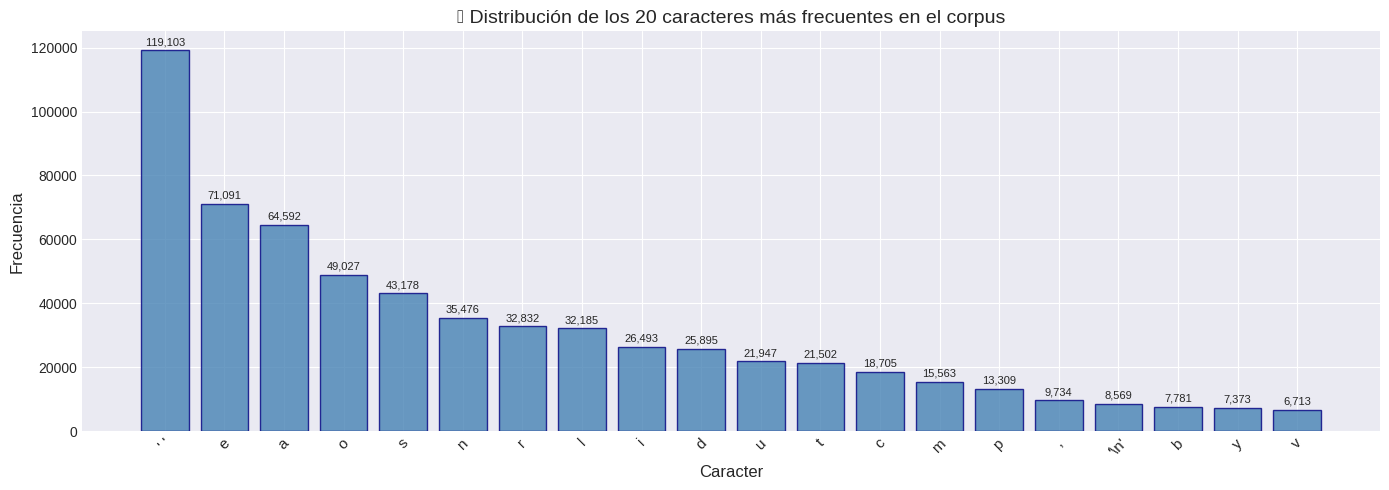

In [26]:
# Análisis de distribución de caracteres en el corpus
"""char_counts = Counter(corpus)
most_common = char_counts.most_common(20)

fig, ax = plt.subplots(figsize=(14, 5))
chars, counts = zip(*most_common)
chars_display = [repr(c) if c in [' ', '\n', '\t'] else c for c in chars]
bars = ax.bar(chars_display, counts, color='steelblue', edgecolor='navy', alpha=0.8)
ax.set_xlabel('Caracter', fontsize=12)
ax.set_ylabel('Frecuencia', fontsize=12)
ax.set_title('📊 Distribución de los 20 caracteres más frecuentes en el corpus', fontsize=14)
plt.xticks(rotation=45, fontsize=11)

# Añadir valores encima de las barras
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000,
            f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()"""

---
## 3. Tokenización por Caracteres

En un modelo de lenguaje por caracteres, cada carácter único del corpus representa un token. Esto nos permite:
- **Vocabulario pequeño**: Típicamente 50-100 caracteres vs miles de palabras
- **Flexibilidad**: Puede manejar cualquier palabra, incluso neologismos
- **Captura morfológica**: Aprende patrones dentro de las palabras

# Crear vocabulario de caracteres únicos (ordenado para reproducibilidad)

In [27]:
chars_vocab = sorted(set(corpus))
vocab_size = len(chars_vocab)

print(f"📝 Tamaño del vocabulario: {vocab_size} caracteres únicos")
print(f"\n🔤 Caracteres en el vocabulario:")
print(chars_vocab)

📝 Tamaño del vocabulario: 58 caracteres únicos

🔤 Caracteres en el vocabulario:
['\t', '\n', ' ', '!', '"', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü', '—']


In [28]:
# Crear diccionarios de mapeo caracter <-> índice
char2idx = {ch: idx for idx, ch in enumerate(chars_vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}

# Mostrar ejemplos de mapeo
print("🔗 Ejemplos de mapeo char2idx:")
for ch in ['a', 'e', 'i', 'o', 'u', ' ', '.', ',', 'ñ']:
    if ch in char2idx:
        print(f"  '{ch}' -> {char2idx[ch]}")

🔗 Ejemplos de mapeo char2idx:
  'a' -> 24
  'e' -> 28
  'i' -> 32
  'o' -> 37
  'u' -> 43
  ' ' -> 2
  '.' -> 9
  ',' -> 7
  'ñ' -> 53


In [29]:
# Tokenizar el corpus completo (convertir caracteres a índices)
tokenized_corpus = np.array([char2idx[ch] for ch in corpus], dtype=np.int64)

print(f"📊 Corpus tokenizado - shape: {tokenized_corpus.shape}")
print(f"\n🔢 Primeros 50 tokens:")
print(tokenized_corpus[:50])
print(f"\n📜 Texto correspondiente:")
print(f"'{corpus[:50]}'")

📊 Corpus tokenizado - shape: (681633,)

🔢 Primeros 50 tokens:
[ 2 31 50 25 34 24 35 28  7  2 35 43 41 24  7  2 27 28  2 24 39 43 28 34
  2 44 24 40 54 36  2 27 28  2 35 43 34 42 32 29 37 40 35 28  2 32 36 30
 28 36]

📜 Texto correspondiente:
' háblame, musa, de aquel varón de multiforme ingen'


---
## 4. Estructuración del Dataset

### 4.1 Definición del Tamaño de Contexto

El tamaño de contexto define cuántos caracteres previos utilizará el modelo para predecir el siguiente. En modelos por caracteres podemos usar contextos más largos.

In [30]:
# Definir tamaño de contexto (hiperparámetro)
MAX_CONTEXT_SIZE = 100

print(f"⚙️ Tamaño de contexto: {MAX_CONTEXT_SIZE} caracteres")
print(f"📝 Esto equivale aproximadamente a {MAX_CONTEXT_SIZE // 5} palabras (asumiendo ~5 caracteres por palabra)")

⚙️ Tamaño de contexto: 100 caracteres
📝 Esto equivale aproximadamente a 20 palabras (asumiendo ~5 caracteres por palabra)


### 4.2 División en Entrenamiento y Validación

Dividiremos el corpus secuencialmente: **90% para entrenamiento** y **10% para validación**.

In [31]:
# Proporción para validación
p_val = 0.1

# Calcular índice de división
split_idx = int(len(tokenized_corpus) * (1 - p_val))

# Dividir corpus tokenizado
train_corpus = tokenized_corpus[:split_idx]
val_corpus = tokenized_corpus[split_idx:]

print(f"📊 División del corpus:")
print(f"  • Entrenamiento: {len(train_corpus):,} caracteres ({len(train_corpus)/len(tokenized_corpus)*100:.1f}%)")
print(f"  • Validación: {len(val_corpus):,} caracteres ({len(val_corpus)/len(tokenized_corpus)*100:.1f}%)")

📊 División del corpus:
  • Entrenamiento: 613,469 caracteres (90.0%)
  • Validación: 68,164 caracteres (10.0%)


### 4.3 Creación de Secuencias de Entrenamiento

Estructuramos el problema como **many-to-many**:
- **Entrada**: secuencia de tokens $[x_0, x_1, ..., x_N]$
- **Target**: secuencia desplazada $[x_1, x_2, ..., x_{N+1}]$

Esta estructura permite que cada posición contribuya al gradiente, mejorando el aprendizaje.

In [32]:
def create_sequences(corpus_data, seq_length):
    """
    Crea secuencias de entrada y target para entrenamiento many-to-many.

    Args:
        corpus_data: Array de tokens
        seq_length: Longitud de cada secuencia

    Returns:
        X: Array de secuencias de entrada (n_sequences, seq_length)
        y: Array de secuencias target (n_sequences, seq_length)
    """
    n_sequences = len(corpus_data) - seq_length

    X = np.zeros((n_sequences, seq_length), dtype=np.int64)
    y = np.zeros((n_sequences, seq_length), dtype=np.int64)

    for i in range(n_sequences):
        X[i] = corpus_data[i:i + seq_length]
        y[i] = corpus_data[i + 1:i + seq_length + 1]

    return X, y

# Crear secuencias de entrenamiento
X_train, y_train = create_sequences(train_corpus, MAX_CONTEXT_SIZE)

print(f"📦 Secuencias de entrenamiento:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • y_train shape: {y_train.shape}")

📦 Secuencias de entrenamiento:
  • X_train shape: (613369, 100)
  • y_train shape: (613369, 100)


# Verificar alineación entre entrada y target

In [33]:
print("🔍 Ejemplo de alineación entrada-target:")
print(f"\n📥 Entrada (X[0]):")
print(''.join([idx2char[idx] for idx in X_train[0]]))
print(f"\n📤 Target (y[0]):")
print(''.join([idx2char[idx] for idx in y_train[0]]))
print("\n(Observa cómo el target está desplazado un carácter a la derecha)")

🔍 Ejemplo de alineación entrada-target:

📥 Entrada (X[0]):
 háblame, musa, de aquel varón de multiforme ingenio que, después de 
destruir la sacra ciudad de tr

📤 Target (y[0]):
háblame, musa, de aquel varón de multiforme ingenio que, después de 
destruir la sacra ciudad de tro

(Observa cómo el target está desplazado un carácter a la derecha)


In [34]:
# OPTIMIZADO: Batch size más grande con embeddings (usa menos memoria que one-hot)
# Con una L4 de 24GB y embeddings, podemos usar batch sizes mucho más grandes
BATCH_SIZE = 1024 if torch.cuda.is_available() else 128

# Configurar num_workers para carga paralela de datos
# En macOS usar 0, en Linux/Windows usar 2-4
import platform
NUM_WORKERS = 0 if platform.system() == 'Darwin' else 2

# pin_memory=True acelera la transferencia CPU->GPU
PIN_MEMORY = torch.cuda.is_available()

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.long),
    torch.tensor(y_train, dtype=torch.long)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

# Crear secuencias y DataLoader de validación
X_val, y_val = create_sequences(val_corpus, MAX_CONTEXT_SIZE)

val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.long),
    torch.tensor(y_val, dtype=torch.long)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"📦 DataLoaders creados:")
print(f"  • Batches de entrenamiento: {len(train_loader)}")
print(f"  • Batches de validación: {len(val_loader)}")
print(f"  • Tamaño de batch: {BATCH_SIZE}")
print(f"  • pin_memory: {PIN_MEMORY}")
print(f"  • num_workers: {NUM_WORKERS}")

📦 DataLoaders creados:
  • Batches de entrenamiento: 598
  • Batches de validación: 67
  • Tamaño de batch: 1024
  • pin_memory: True
  • num_workers: 2


---
## 5. Definición de Arquitecturas RNN

Implementaremos tres arquitecturas basadas en unidades recurrentes:
1. **SimpleRNN** (Celda de Elman): La más básica, puede sufrir de gradientes que desaparecen
2. **LSTM** (Long Short-Term Memory): Mejor para dependencias largas gracias a compuertas
3. **GRU** (Gated Recurrent Unit): Balance entre complejidad y rendimiento

In [69]:
class CharLanguageModel(nn.Module):
    """
    Modelo de lenguaje a nivel de caracteres con arquitectura RNN configurable.
    Soporta: RNN, LSTM y GRU.

    OPTIMIZADO:
    - Usa nn.Embedding en lugar de one-hot encoding para mayor eficiencia en GPU.
    - Incluye regularización para reducir overfitting.
    """

    def __init__(self, vocab_size, hidden_size=256, num_layers=2,
                 rnn_type='lstm', dropout=0.2, embedding_dim=128,
                 embed_dropout=0.1, locked_dropout=False):
        super().__init__()

        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type.lower()
        self.embedding_dim = embedding_dim

        # Seleccionar tipo de celda recurrente
        rnn_classes = {'rnn': nn.RNN, 'lstm': nn.LSTM, 'gru': nn.GRU}

        if self.rnn_type not in rnn_classes:
            raise ValueError(f"rnn_type debe ser 'rnn', 'lstm' o 'gru'")

        # OPTIMIZACIÓN: Usar embedding en lugar de one-hot encoding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # REGULARIZACIÓN: Dropout en embeddings (reduce overfitting)
        self.embed_dropout = nn.Dropout(embed_dropout)

        # Capa recurrente (ahora recibe embedding_dim, no vocab_size)
        self.rnn = rnn_classes[self.rnn_type](
            input_size=embedding_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # REGULARIZACIÓN: Dropout antes de la capa de salida
        self.dropout = nn.Dropout(dropout)

        # REGULARIZACIÓN: Layer Normalization (estabiliza entrenamiento)
        self.layer_norm = nn.LayerNorm(hidden_size)

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        # Embedding lookup con dropout
        x_embedded = self.embedding(x)
        x_embedded = self.embed_dropout(x_embedded)  # Dropout en embeddings

        # Forward pass RNN
        rnn_out, hidden = self.rnn(x_embedded, hidden)

        # Layer normalization + Dropout antes de la capa lineal
        rnn_out = self.layer_norm(rnn_out)
        rnn_out = self.dropout(rnn_out)
        logits = self.fc(rnn_out)

        return logits, hidden

    def init_hidden(self, batch_size, device):
        if self.rnn_type == 'lstm':
            return (
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
            )
        else:
            return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

✅ Clase CharLanguageModel definida (con regularización anti-overfitting)


```
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
```

In [36]:
# Comparar arquitecturas en términos de parámetros
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("📊 Comparación de arquitecturas:")
print("=" * 50)
for rnn_type in ['rnn', 'lstm', 'gru']:
    model_temp = CharLanguageModel(
        vocab_size=vocab_size,
        hidden_size=256,
        num_layers=2,
        rnn_type=rnn_type
    )
    n_params = count_parameters(model_temp)
    print(f"  {rnn_type.upper():>5}: {n_params:>10,} parámetros")
print("=" * 50)

📊 Comparación de arquitecturas:
    RNN:    252,730 parámetros
   LSTM:    943,930 parámetros
    GRU:    713,530 parámetros


---
## 6. Entrenamiento del Modelo

### 6.1 Funciones de Entrenamiento y Evaluación

In [37]:
def compute_perplexity(model, data_loader, criterion, device, use_amp=True):
    """
    Calcula la perplejidad del modelo en un conjunto de datos.
    Perplejidad = exp(loss promedio). Menor perplejidad = mejor modelo.

    OPTIMIZADO: Usa autocast para evaluación más rápida.
    """
    model.eval()
    total_loss = 0
    total_tokens = 0
    use_amp = use_amp and torch.cuda.is_available()

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)

            # OPTIMIZACIÓN: autocast para evaluación más rápida
            with torch.amp.autocast('cuda', enabled=use_amp):
                logits, _ = model(X_batch)
                loss = criterion(logits.view(-1, model.vocab_size), y_batch.view(-1))

            total_loss += loss.item() * y_batch.numel()
            total_tokens += y_batch.numel()

    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)

    return perplexity, avg_loss

print("✅ Función compute_perplexity definida (OPTIMIZADA con AMP)")

✅ Función compute_perplexity definida (OPTIMIZADA con AMP)


In [70]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=0.001,
                patience=5, device='cpu', clip_grad=5.0, use_amp=True,
                weight_decay=1e-5, label_smoothing=0.1):
    """
    Entrena el modelo con early stopping basado en perplejidad de validación.

    OPTIMIZADO:
    - Mixed Precision Training (AMP) para acelerar entrenamiento en GPU.
    - Weight decay (L2 regularization) para reducir overfitting.
    - Label smoothing para mejorar generalización.
    """
    model = model.to(device)

    # REGULARIZACIÓN: Label smoothing (evita que el modelo sea demasiado confiado)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # REGULARIZACIÓN: Weight decay (L2 regularization en los pesos)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)

    # OPTIMIZACIÓN: Mixed Precision Training (AMP) para GPUs modernas
    # Esto puede dar 2-3x de aceleración en GPUs con Tensor Cores (V100, A100, L4, etc.)
    use_amp = use_amp and torch.cuda.is_available()
    scaler = torch.amp.GradScaler('cuda', enabled=use_amp)

    if use_amp:
        print("⚡ Mixed Precision Training (AMP) ACTIVADO - Entrenamiento acelerado")

    history = {'train_loss': [], 'train_ppl': [], 'val_loss': [], 'val_ppl': []}
    best_val_ppl = float('inf')
    patience_counter = 0
    best_model_state = None

    print(f"🚀 Iniciando entrenamiento - {model.rnn_type.upper()}")
    print("=" * 70)

    for epoch in range(num_epochs):
        # --- Fase de Entrenamiento ---
        model.train()
        total_loss = 0
        total_tokens = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device, non_blocking=True)  # non_blocking para carga asíncrona
            y_batch = y_batch.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)  # Más eficiente que zero_grad()

            # OPTIMIZACIÓN: autocast para mixed precision
            with torch.amp.autocast('cuda', enabled=use_amp):
                logits, _ = model(X_batch)
                loss = criterion(logits.view(-1, model.vocab_size), y_batch.view(-1))

            # Backward con GradScaler para AMP
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item() * y_batch.numel()
            total_tokens += y_batch.numel()

        train_loss = total_loss / total_tokens
        train_ppl = np.exp(train_loss)

        # --- Fase de Validación ---
        val_ppl, val_loss = compute_perplexity(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_ppl'].append(train_ppl)
        history['val_loss'].append(val_loss)
        history['val_ppl'].append(val_ppl)

        print(f"Época {epoch+1:2d}/{num_epochs} | Train Loss: {train_loss:.4f} | "
              f"Train PPL: {train_ppl:7.2f} | Val Loss: {val_loss:.4f} | Val PPL: {val_ppl:7.2f}", end='')

        if val_ppl < best_val_ppl:
            best_val_ppl = val_ppl
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(" Best!")
        else:
            patience_counter += 1
            print(f" (paciencia: {patience_counter}/{patience})")
            if patience_counter >= patience:
                print(f"\n⏹️ Early stopping en época {epoch+1}")
                break

    print("=" * 70)
    print(f"✅ Mejor perplejidad de validación: {best_val_ppl:.2f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

print("✅ Función train_model definida (OPTIMIZADA con AMP)")

✅ Función train_model definida (OPTIMIZADA con AMP)


### 6.2 Entrenamiento de los Tres Modelos (SimpleRNN, LSTM, GRU)

In [72]:
# Hiperparámetros de entrenamiento
# Arquitectura del modelo
HIDDEN_SIZE = 256
NUM_LAYERS = 2
EMBEDDING_DIM = 128

# REGULARIZACIÓN - Valores más altos para combatir overfitting
DROPOUT = 0.5           # Aumentado de 0.3 → 0.5 (más agresivo)
EMBED_DROPOUT = 0.2     # Dropout en embeddings

# Entrenamiento
LEARNING_RATE = 0.001   # Reducido de 0.002 → 0.001 (más estable)
NUM_EPOCHS = 30
PATIENCE = 3

# REGULARIZACIÓN adicional
WEIGHT_DECAY = 1e-5     # L2 regularization
LABEL_SMOOTHING = 0.1   # Suavizado de etiquetas

# Diccionarios para almacenar modelos e historiales
models = {}
histories = {}

print("⚙️ Hiperparámetros configurados (ANTI-OVERFITTING):")
print(f"  📐 Arquitectura:")
print(f"     • Hidden Size: {HIDDEN_SIZE}")
print(f"     • Num Layers: {NUM_LAYERS}")
print(f"     • Embedding Dim: {EMBEDDING_DIM}")
print(f"  🛡️ Regularización:")
print(f"     • Dropout RNN: {DROPOUT}")
print(f"     • Dropout Embeddings: {EMBED_DROPOUT}")
print(f"     • Weight Decay (L2): {WEIGHT_DECAY}")
print(f"     • Label Smoothing: {LABEL_SMOOTHING}")
print(f"  🎯 Entrenamiento:")
print(f"     • Learning Rate: {LEARNING_RATE}")
print(f"     • Max Epochs: {NUM_EPOCHS}")
print(f"     • Patience: {PATIENCE}")

⚙️ Hiperparámetros configurados (ANTI-OVERFITTING):
  📐 Arquitectura:
     • Hidden Size: 256
     • Num Layers: 2
     • Embedding Dim: 128
  🛡️ Regularización:
     • Dropout RNN: 0.5
     • Dropout Embeddings: 0.2
     • Weight Decay (L2): 1e-05
     • Label Smoothing: 0.1
  🎯 Entrenamiento:
     • Learning Rate: 0.001
     • Max Epochs: 30
     • Patience: 5


In [73]:
# Entrenar modelo SimpleRNN
print("\n" + "="*70)
print("📦 ENTRENANDO MODELO: SimpleRNN")
print("="*70 + "\n")

models['rnn'] = CharLanguageModel(
    vocab_size=vocab_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    rnn_type='rnn',
    dropout=DROPOUT,
    embedding_dim=EMBEDDING_DIM,
    embed_dropout=EMBED_DROPOUT
)

histories['rnn'] = train_model(
    models['rnn'], train_loader, val_loader,
    num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
    patience=PATIENCE, device=device,
    weight_decay=WEIGHT_DECAY, label_smoothing=LABEL_SMOOTHING
)


📦 ENTRENANDO MODELO: SimpleRNN

⚡ Mixed Precision Training (AMP) ACTIVADO - Entrenamiento acelerado
🚀 Iniciando entrenamiento - RNN
Época  1/30 | Train Loss: 2.4353 | Train PPL:   11.42 | Val Loss: 2.1365 | Val PPL:    8.47 Best!
Época  2/30 | Train Loss: 2.2245 | Train PPL:    9.25 | Val Loss: 2.0509 | Val PPL:    7.77 Best!
Época  3/30 | Train Loss: 2.1631 | Train PPL:    8.70 | Val Loss: 2.0083 | Val PPL:    7.45 Best!
Época  4/30 | Train Loss: 2.1298 | Train PPL:    8.41 | Val Loss: 1.9826 | Val PPL:    7.26 Best!
Época  5/30 | Train Loss: 2.1088 | Train PPL:    8.24 | Val Loss: 1.9752 | Val PPL:    7.21 Best!
Época  6/30 | Train Loss: 2.0940 | Train PPL:    8.12 | Val Loss: 1.9614 | Val PPL:    7.11 Best!
Época  7/30 | Train Loss: 2.0832 | Train PPL:    8.03 | Val Loss: 1.9526 | Val PPL:    7.05 Best!
Época  8/30 | Train Loss: 2.0748 | Train PPL:    7.96 | Val Loss: 1.9491 | Val PPL:    7.02 Best!
Época  9/30 | Train Loss: 2.0679 | Train PPL:    7.91 | Val Loss: 1.9440 | Val PPL:

In [74]:
# Entrenar modelo LSTM
print("\n" + "="*70)
print("📦 ENTRENANDO MODELO: LSTM")
print("="*70 + "\n")

models['lstm'] = CharLanguageModel(
    vocab_size=vocab_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    rnn_type='lstm',
    dropout=DROPOUT,
    embedding_dim=EMBEDDING_DIM,
    embed_dropout=EMBED_DROPOUT
)

histories['lstm'] = train_model(
    models['lstm'], train_loader, val_loader,
    num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
    patience=PATIENCE, device=device,
    weight_decay=WEIGHT_DECAY, label_smoothing=LABEL_SMOOTHING
)


📦 ENTRENANDO MODELO: LSTM

⚡ Mixed Precision Training (AMP) ACTIVADO - Entrenamiento acelerado
🚀 Iniciando entrenamiento - LSTM
Época  1/30 | Train Loss: 2.2752 | Train PPL:    9.73 | Val Loss: 1.9304 | Val PPL:    6.89 Best!
Época  2/30 | Train Loss: 1.9660 | Train PPL:    7.14 | Val Loss: 1.8395 | Val PPL:    6.29 Best!
Época  3/30 | Train Loss: 1.8952 | Train PPL:    6.65 | Val Loss: 1.8056 | Val PPL:    6.08 Best!
Época  4/30 | Train Loss: 1.8598 | Train PPL:    6.42 | Val Loss: 1.7895 | Val PPL:    5.99 Best!
Época  5/30 | Train Loss: 1.8371 | Train PPL:    6.28 | Val Loss: 1.7806 | Val PPL:    5.93 Best!
Época  6/30 | Train Loss: 1.8211 | Train PPL:    6.18 | Val Loss: 1.7741 | Val PPL:    5.90 Best!
Época  7/30 | Train Loss: 1.8085 | Train PPL:    6.10 | Val Loss: 1.7710 | Val PPL:    5.88 Best!
Época  8/30 | Train Loss: 1.7981 | Train PPL:    6.04 | Val Loss: 1.7720 | Val PPL:    5.88 (paciencia: 1/5)
Época  9/30 | Train Loss: 1.7894 | Train PPL:    5.99 | Val Loss: 1.7676 | V

In [75]:
# Entrenar modelo GRU
print("\n" + "="*70)
print("📦 ENTRENANDO MODELO: GRU")
print("="*70 + "\n")

models['gru'] = CharLanguageModel(
    vocab_size=vocab_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    rnn_type='gru',
    dropout=DROPOUT,
    embedding_dim=EMBEDDING_DIM,
    embed_dropout=EMBED_DROPOUT
)

histories['gru'] = train_model(
    models['gru'], train_loader, val_loader,
    num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
    patience=PATIENCE, device=device,
    weight_decay=WEIGHT_DECAY, label_smoothing=LABEL_SMOOTHING
)


📦 ENTRENANDO MODELO: GRU

⚡ Mixed Precision Training (AMP) ACTIVADO - Entrenamiento acelerado
🚀 Iniciando entrenamiento - GRU
Época  1/30 | Train Loss: 2.2825 | Train PPL:    9.80 | Val Loss: 1.9460 | Val PPL:    7.00 Best!
Época  2/30 | Train Loss: 1.9967 | Train PPL:    7.36 | Val Loss: 1.8517 | Val PPL:    6.37 Best!
Época  3/30 | Train Loss: 1.9290 | Train PPL:    6.88 | Val Loss: 1.8249 | Val PPL:    6.20 Best!
Época  4/30 | Train Loss: 1.8951 | Train PPL:    6.65 | Val Loss: 1.8101 | Val PPL:    6.11 Best!
Época  5/30 | Train Loss: 1.8734 | Train PPL:    6.51 | Val Loss: 1.8075 | Val PPL:    6.10 Best!
Época  6/30 | Train Loss: 1.8578 | Train PPL:    6.41 | Val Loss: 1.8014 | Val PPL:    6.06 Best!
Época  7/30 | Train Loss: 1.8459 | Train PPL:    6.33 | Val Loss: 1.7951 | Val PPL:    6.02 Best!
Época  8/30 | Train Loss: 1.8364 | Train PPL:    6.27 | Val Loss: 1.7910 | Val PPL:    6.00 Best!
Época  9/30 | Train Loss: 1.8283 | Train PPL:    6.22 | Val Loss: 1.7899 | Val PPL:    5.

In [76]:
histories.keys()

dict_keys(['rnn', 'lstm', 'gru'])

/tmp/ipython-input-3895071053.py:54: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/tmp/ipython-input-3895071053.py:54: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


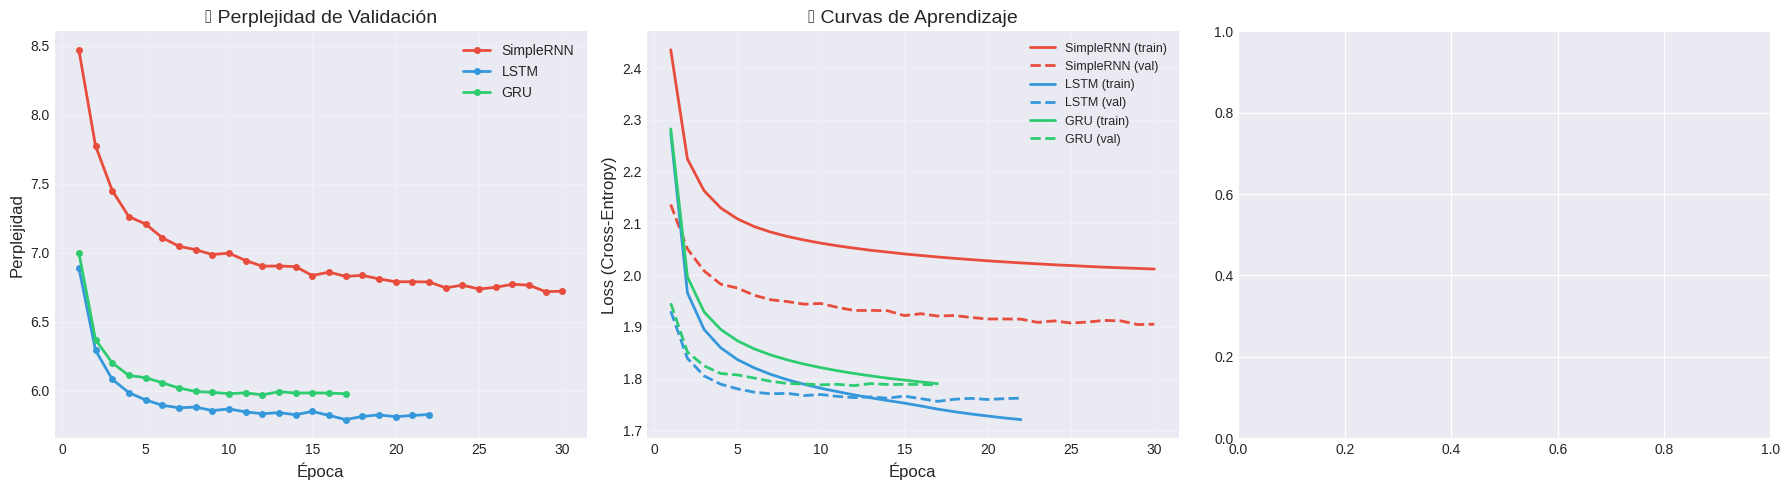


📊 Resumen de Modelos Entrenados:
Modelo         Parámetros    Mejor PPL   Épocas Tiempo/Época
---------------------------------------------------------------------------
SimpleRNN         253,242         6.72       30          N/A
LSTM              944,442         5.79       22          N/A
GRU               714,042         5.97       17          N/A


In [77]:
# Graficar curvas de entrenamiento comparativas
#fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'rnn': '#e74c3c', 'lstm': '#3498db', 'gru': '#2ecc71'}
labels = {'rnn': 'SimpleRNN', 'lstm': 'LSTM', 'gru': 'GRU'}

# Solo graficar si hay modelos entrenados
if histories:
    # Crear figura con 3 subplots (incluyendo tiempos)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1. Perplejidad de validación
    for model_type, history in histories.items():
        epochs = range(1, len(history['val_ppl']) + 1)
        axes[0].plot(epochs, history['val_ppl'], color=colors[model_type],
                     label=labels[model_type], linewidth=2, marker='o', markersize=4)
    axes[0].set_xlabel('Época', fontsize=12)
    axes[0].set_ylabel('Perplejidad', fontsize=12)
    axes[0].set_title('📈 Perplejidad de Validación', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # 2. Loss de entrenamiento y validación
    for model_type, history in histories.items():
        epochs = range(1, len(history['train_loss']) + 1)
        axes[1].plot(epochs, history['train_loss'], color=colors[model_type],
                     label=f"{labels[model_type]} (train)", linewidth=2, linestyle='-')
        axes[1].plot(epochs, history['val_loss'], color=colors[model_type],
                     label=f"{labels[model_type]} (val)", linewidth=2, linestyle='--')
    axes[1].set_xlabel('Época', fontsize=12)
    axes[1].set_ylabel('Loss (Cross-Entropy)', fontsize=12)
    axes[1].set_title('📉 Curvas de Aprendizaje', fontsize=14)
    axes[1].legend(loc='upper right', fontsize=9)
    axes[1].grid(True, alpha=0.3)

    # 3. Tiempos por componente (del último modelo entrenado)
    last_model = list(histories.keys())[-1]
    if 'timing' in histories[last_model]:
        timing = histories[last_model]['timing']
        components = ['data_load', 'forward', 'backward', 'optimizer', 'validation']
        comp_labels = ['Carga\nDatos', 'Forward', 'Backward', 'Optimizer', 'Validación']
        avg_times = [np.mean(timing[c]) for c in components]

        bars = axes[2].bar(comp_labels, avg_times, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12', '#9b59b6'])
        axes[2].set_ylabel('Tiempo (segundos)', fontsize=12)
        axes[2].set_title(f'⏱️ Tiempo por Componente ({labels[last_model]})', fontsize=14)
        axes[2].grid(True, alpha=0.3, axis='y')

        # Añadir valores encima de las barras
        for bar, t in zip(bars, avg_times):
            axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{t:.2f}s', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Tabla resumen de modelos
    print("\n📊 Resumen de Modelos Entrenados:")
    print("=" * 75)
    print(f"{'Modelo':<12} {'Parámetros':>12} {'Mejor PPL':>12} {'Épocas':>8} {'Tiempo/Época':>12}")
    print("-" * 75)
    for model_type in histories.keys():
        n_params = count_parameters(models[model_type])
        best_ppl = min(histories[model_type]['val_ppl'])
        n_epochs = len(histories[model_type]['val_ppl'])
        if 'timing' in histories[model_type]:
            avg_time = np.mean(histories[model_type]['timing']['epoch_total'])
            time_str = f"{avg_time:.1f}s"
        else:
            time_str = "N/A"
        print(f"{labels[model_type]:<12} {n_params:>12,} {best_ppl:>12.2f} {n_epochs:>8} {time_str:>12}")
    print("=" * 75)
else:
    print("⚠️ No hay modelos entrenados para mostrar")

---
## 7. Generación de Secuencias

Implementaremos tres estrategias de generación:
1. **Greedy Search**: Selecciona siempre el carácter más probable (determinístico)
2. **Beam Search Determinístico**: Mantiene los k mejores candidatos
3. **Beam Search Estocástico**: Muestreo con temperatura para diversidad

In [78]:
# Seleccionar el mejor modelo para generación
best_model_type = min(histories, key=lambda x: min(histories[x]['val_ppl']))
model = models[best_model_type]
print(f"🏆 Usando modelo: {best_model_type.upper()} (mejor perplejidad de validación)")
print(f"   Perplejidad: {min(histories[best_model_type]['val_ppl']):.2f}")

🏆 Usando modelo: LSTM (mejor perplejidad de validación)
   Perplejidad: 5.79


### 7.1 Greedy Search

En Greedy Search, siempre seleccionamos el carácter con mayor probabilidad. Es determinístico pero puede producir secuencias repetitivas.

In [79]:
def greedy_search(model, seed_text, max_length, num_chars, device='cpu'):
    """
    Genera texto usando búsqueda voraz (greedy search).

    Args:
        model: Modelo de lenguaje entrenado
        seed_text: Texto inicial (semilla)
        max_length: Tamaño máximo de contexto
        num_chars: Número de caracteres a generar
        device: Dispositivo de cómputo

    Returns:
        generated_text: Texto generado (incluyendo semilla)
    """
    model.eval()
    model = model.to(device)
    generated_text = seed_text.lower()

    with torch.no_grad():
        for _ in range(num_chars):
            # Tokenizar el texto actual
            tokens = [char2idx.get(ch, 0) for ch in generated_text[-max_length:]]

            # Pad si es necesario
            if len(tokens) < max_length:
                tokens = [0] * (max_length - len(tokens)) + tokens

            x = torch.tensor([tokens], dtype=torch.long, device=device)
            logits, _ = model(x)

            # Seleccionar el carácter más probable (greedy)
            next_char_idx = logits[0, -1, :].argmax().item()
            next_char = idx2char[next_char_idx]
            generated_text += next_char

    return generated_text

print("✅ Función greedy_search definida")

✅ Función greedy_search definida


In [80]:
# Ejemplos de generación con Greedy Search
seed_texts = [
    "el señor fogg",
    "pasepartout dijo",
    "la vuelta al mundo"
]

print("="*70)
print("🔍 GREEDY SEARCH - Generación de texto")
print("="*70)

for seed in seed_texts:
    generated = greedy_search(model, seed, MAX_CONTEXT_SIZE, num_chars=150, device=device)
    print(f"\n📝 Semilla: '{seed}'")
    print("-"*50)
    print(generated)
    print()


🔍 GREEDY SEARCH - Generación de texto

📝 Semilla: 'el señor fogg'
--------------------------------------------------
el señor foggamos a la 
casa de odiseo la de las deidades que se hallan en el palacio de aquel 
palacio de aquel palacio de aquel palacio de aquel palacio de aquel


📝 Semilla: 'pasepartout dijo'
--------------------------------------------------
pasepartout dijo, y 
allí le dijo estas aladas palabras: —¡oh amigos! no te conduzca a la casa de odiseo la de las 
compañeros y de las manos de la casa de odiseo y e


📝 Semilla: 'la vuelta al mundo'
--------------------------------------------------
la vuelta al mundo 
para que los pretendientes se acostaron a la casa de odiseo la de las 
compañeros y de las manos de la casa de odiseo y el divinal odiseo y el 
pala



### 7.2 Muestreo con Temperatura

La temperatura controla la "creatividad" del modelo:
- **T < 1**: Más conservador, secuencias predecibles
- **T = 1**: Distribución original del modelo  
- **T > 1**: Más aleatorio, secuencias diversas/caóticas

In [81]:
def sample_with_temperature(model, seed_text, max_length, num_chars,
                            temperature=1.0, device='cpu'):
    """
    Genera texto usando muestreo con temperatura.

    Args:
        model: Modelo de lenguaje entrenado
        seed_text: Texto inicial
        max_length: Tamaño máximo de contexto
        num_chars: Número de caracteres a generar
        temperature: Parámetro de temperatura (0 < T)
        device: Dispositivo de cómputo

    Returns:
        generated_text: Texto generado
    """
    model.eval()
    model = model.to(device)
    generated_text = seed_text.lower()

    with torch.no_grad():
        for _ in range(num_chars):
            tokens = [char2idx.get(ch, 0) for ch in generated_text[-max_length:]]

            if len(tokens) < max_length:
                tokens = [0] * (max_length - len(tokens)) + tokens

            x = torch.tensor([tokens], dtype=torch.long, device=device)
            logits, _ = model(x)

            # Aplicar temperatura
            logits_scaled = logits[0, -1, :] / temperature
            probs = F.softmax(logits_scaled, dim=-1)

            # Muestrear de la distribución
            next_char_idx = torch.multinomial(probs, num_samples=1).item()
            next_char = idx2char[next_char_idx]
            generated_text += next_char

    return generated_text

print("✅ Función sample_with_temperature definida")

✅ Función sample_with_temperature definida


In [82]:
# Demostrar efecto de la temperatura
seed = "el viaje comenzó"
temperatures = [0.2, 0.5, 0.8, 1.0, 1.2, 1.5]

print("="*70)
print("🌡️ EFECTO DE LA TEMPERATURA EN LA GENERACIÓN")
print(f"📝 Semilla: '{seed}'")
print("="*70)

for temp in temperatures:
    generated = sample_with_temperature(
        model, seed, MAX_CONTEXT_SIZE,
        num_chars=100, temperature=temp, device=device
    )
    print(f"\n🌡️ Temperatura = {temp}")
    print("-"*50)
    print(generated)

🌡️ EFECTO DE LA TEMPERATURA EN LA GENERACIÓN
📝 Semilla: 'el viaje comenzó'

🌡️ Temperatura = 0.2
--------------------------------------------------
el viaje comenzó a 
decirles a los pretendientes. así dijo. el corazón arribamos a la patria tierra. así dijo. el co

🌡️ Temperatura = 0.5
--------------------------------------------------
el viaje comenzó a 
decirles: —¡antínoo! no por si persegua en la mano de la 
muerte y a tu madre a los pretendiente

🌡️ Temperatura = 0.8
--------------------------------------------------
el viaje comenzó en algunas te lo 
señalas de púnico y le dejo preclaro de notices, con el transa de fuerza de patri

🌡️ Temperatura = 1.0
--------------------------------------------------
el viaje comenzó a 
decirles el pecho, y a quien se quedó con afhorta: lo n?1s6o desamparaba 
un primero a los a que

🌡️ Temperatura = 1.2
--------------------------------------------------
el viaje comenzó0 de esnacino	? ¡así hubo afirmaó se l4nfado mce. y -al pu	áb4mo3te, v94t9ro

### 7.3 Beam Search Determinístico

Beam Search mantiene múltiples hipótesis (beams) y expande las más prometedoras. Es más sofisticado que greedy pero sigue siendo determinístico.

In [83]:
def beam_search_deterministic(model, seed_text, max_length, num_chars,
                              beam_width=5, device='cpu'):
    """
    Genera texto usando beam search determinístico.

    Args:
        model: Modelo de lenguaje entrenado
        seed_text: Texto inicial
        max_length: Tamaño máximo de contexto
        num_chars: Número de caracteres a generar
        beam_width: Número de hipótesis a mantener
        device: Dispositivo de cómputo

    Returns:
        best_sequence: Mejor secuencia generada
        all_sequences: Lista de todas las secuencias finales con sus scores
    """
    model.eval()
    model = model.to(device)
    seed_text = seed_text.lower()

    # Inicializar beams: (texto, log_prob_acumulada)
    beams = [(seed_text, 0.0)]

    with torch.no_grad():
        for _ in range(num_chars):
            all_candidates = []

            for text, score in beams:
                tokens = [char2idx.get(ch, 0) for ch in text[-max_length:]]
                if len(tokens) < max_length:
                    tokens = [0] * (max_length - len(tokens)) + tokens

                x = torch.tensor([tokens], dtype=torch.long, device=device)
                logits, _ = model(x)
                log_probs = F.log_softmax(logits[0, -1, :], dim=-1)

                # Obtener top-k candidatos
                top_log_probs, top_indices = torch.topk(log_probs, beam_width)

                for log_prob, idx in zip(top_log_probs.cpu().numpy(),
                                         top_indices.cpu().numpy()):
                    new_text = text + idx2char[idx]
                    new_score = score + log_prob
                    all_candidates.append((new_text, new_score))

            # Seleccionar los mejores beam_width candidatos
            all_candidates.sort(key=lambda x: x[1], reverse=True)
            beams = all_candidates[:beam_width]

    # Normalizar scores por longitud
    final_sequences = [(text, score / len(text)) for text, score in beams]
    final_sequences.sort(key=lambda x: x[1], reverse=True)

    return final_sequences[0][0], final_sequences

print("✅ Función beam_search_deterministic definida")

✅ Función beam_search_deterministic definida


In [84]:
# Ejemplos de Beam Search Determinístico
print("="*70)
print("📊 BEAM SEARCH DETERMINÍSTICO")
print("="*70)

seed = "el tren partió de"
beam_widths = [1, 3, 5, 10]

for bw in beam_widths:
    best, all_seqs = beam_search_deterministic(
        model, seed, MAX_CONTEXT_SIZE,
        num_chars=80, beam_width=bw, device=device
    )
    print(f"\n📊 Beam Width = {bw}")
    print(f"Mejor secuencia:")
    print(best)
    print(f"(Score normalizado: {all_seqs[0][1]:.4f})")

📊 BEAM SEARCH DETERMINÍSTICO

📊 Beam Width = 1
Mejor secuencia:
el tren partió de la 
casa de odiseo y el palacio de aquel palacio de aquel palacio de aquel 
pal
(Score normalizado: -0.5489)

📊 Beam Width = 3
Mejor secuencia:
el tren partió de la 
casa de odiseo y en el palacio de odiseo y el divinal odiseo y los pretendi
(Score normalizado: -0.4603)

📊 Beam Width = 5
Mejor secuencia:
el tren partió de esta manera: —¡oh, amigos! no permanecieron en el palacio de la casa de odiseo 
(Score normalizado: -0.4320)

📊 Beam Width = 10
Mejor secuencia:
el tren partió de esta manera: —¡oh dioses! en verdad que se descubrió la hija de la mañana, eos 
(Score normalizado: -0.2894)


### 7.4 Beam Search Estocástico

Combina beam search con muestreo, permitiendo exploración más diversa del espacio de secuencias. La temperatura controla el balance entre exploración y explotación.

In [85]:
def beam_search_stochastic(model, seed_text, max_length, num_chars,
                           beam_width=5, temperature=1.0, device='cpu'):
    """
    Genera texto usando beam search estocástico con temperatura.

    Args:
        model: Modelo de lenguaje entrenado
        seed_text: Texto inicial
        max_length: Tamaño máximo de contexto
        num_chars: Número de caracteres a generar
        beam_width: Número de hipótesis a mantener
        temperature: Parámetro de temperatura para muestreo
        device: Dispositivo de cómputo

    Returns:
        best_sequence: Mejor secuencia generada
        all_sequences: Lista de todas las secuencias finales con sus scores
    """
    model.eval()
    model = model.to(device)
    seed_text = seed_text.lower()

    beams = [(seed_text, 0.0)]

    with torch.no_grad():
        for _ in range(num_chars):
            all_candidates = []

            for text, score in beams:
                tokens = [char2idx.get(ch, 0) for ch in text[-max_length:]]
                if len(tokens) < max_length:
                    tokens = [0] * (max_length - len(tokens)) + tokens

                x = torch.tensor([tokens], dtype=torch.long, device=device)
                logits, _ = model(x)

                # Aplicar temperatura
                logits_scaled = logits[0, -1, :] / temperature
                probs = F.softmax(logits_scaled, dim=-1)
                log_probs = torch.log(probs + 1e-10)

                # Muestrear beam_width candidatos según la distribución
                sampled_indices = torch.multinomial(probs, num_samples=min(beam_width, len(probs)),
                                                   replacement=False)

                for idx in sampled_indices.cpu().numpy():
                    new_text = text + idx2char[idx]
                    new_score = score + log_probs[idx].item()
                    all_candidates.append((new_text, new_score))

            all_candidates.sort(key=lambda x: x[1], reverse=True)
            beams = all_candidates[:beam_width]

    final_sequences = [(text, score / len(text)) for text, score in beams]
    final_sequences.sort(key=lambda x: x[1], reverse=True)

    return final_sequences[0][0], final_sequences

print("✅ Función beam_search_stochastic definida")

✅ Función beam_search_stochastic definida


In [86]:
# Comparar Beam Search Estocástico con diferentes temperaturas
print("="*70)
print("🎯 BEAM SEARCH ESTOCÁSTICO - Efecto de la Temperatura")
print("="*70)

seed = "había una vez"
temperatures = [0.3, 0.6, 1.0, 1.5, 5.0]
beam_width = 10

for temp in temperatures:
    best, all_seqs = beam_search_stochastic(
        model, seed, MAX_CONTEXT_SIZE,
        num_chars=100, beam_width=beam_width,
        temperature=temp, device=device
    )
    print(f"\n🌡️ Temperatura = {temp} | Beam Width = {beam_width}")
    print("-"*60)
    print(best)

🎯 BEAM SEARCH ESTOCÁSTICO - Efecto de la Temperatura

🌡️ Temperatura = 0.3 | Beam Width = 10
------------------------------------------------------------
había una vez 
encaminado a la patria tierra. así dijo. entonces el prudente telémaco se descubrió la hija de la 

🌡️ Temperatura = 0.6 | Beam Width = 10
------------------------------------------------------------
había una vez 
encaminado a la patria tierra. así dijo. entonces la divina entre las diosas le dijo estas aladas 

🌡️ Temperatura = 1.0 | Beam Width = 10
------------------------------------------------------------
había una vez en el 
palacio de odiseo laertíada. entonces habló de esta manera: —¡padre zeus! ¡odiseo, fecundo e

🌡️ Temperatura = 1.5 | Beam Width = 10
------------------------------------------------------------
había una vez en el 
palacio del divinal porquerizo que había llegado a los pretendientes, para que el divinal od

🌡️ Temperatura = 5.0 | Beam Width = 10
-----------------------------------------------

In [87]:
all_seqs

[('había una vez ninguno-\n vienes; porque armanda de; cuando dejaron, cumplarándones de hombros. sentóse3e por cada ',
  -2.7467401977133963),
 ('había una vez ninguno-\n vienes; porque armanda de; cuando dejaron, cumplarándones de hombros. sentóse3e por conte',
  -2.748897630556495),
 ('había una vez ninguno-\n vienes; porque armanda de; cuando dejaron, cumplarándones de hombros. sentóse3e por mis\n ',
  -2.7502113738946155),
 ('había una vez ninguno-\n vienes; porque armanda de; cuando dejaron, cumplarándones de hombros. sentóse3e por conta',
  -2.751935684575444),
 ('había una vez ninguno-\n vienes; porque armanda de; cuando dejaron, cumplarándones de hombros. sentóse3e el compao',
  -2.7553102231658664),
 ('había una vez ninguno-\n vienes; porque armanda de; cuando dejaron, cumplarándones de hombros. sentóse3e el compaú',
  -2.7553996617815137),
 ('había una vez ninguno-\n vienes; porque armanda de; cuando dejaron, cumplarándones de hombros. sentóse3e el compa\n',
  -2.75556760129

---
## 8. Comparación de Métodos de Generación

In [88]:
# Comparación lado a lado de todos los métodos
seed = "el detective fix"
num_chars = 120

print("="*70)
print("🔬 COMPARACIÓN DE MÉTODOS DE GENERACIÓN")
print(f"📝 Semilla: '{seed}'")
print(f"📏 Caracteres a generar: {num_chars}")
print("="*70)

# 1. Greedy Search
print("\n📍 GREEDY SEARCH")
print("-"*60)
result_greedy = greedy_search(model, seed, MAX_CONTEXT_SIZE, num_chars, device)
print(result_greedy)

# 2. Muestreo con T=0.5
print(f"\n🎲 MUESTREO CON TEMPERATURA = 0.5")
print("-"*60)
result_sample_05 = sample_with_temperature(model, seed, MAX_CONTEXT_SIZE, num_chars, 0.5, device)
print(result_sample_05)

# 3. Muestreo con T=1.0
print(f"\n🎲 MUESTREO CON TEMPERATURA = 1.0")
print("-"*60)
result_sample_10 = sample_with_temperature(model, seed, MAX_CONTEXT_SIZE, num_chars, 1.0, device)
print(result_sample_10)

# 4. Beam Search Determinístico
print("\n📊 BEAM SEARCH DETERMINÍSTICO (beam_width=5)")
print("-"*60)
result_beam_det, _ = beam_search_deterministic(model, seed, MAX_CONTEXT_SIZE, num_chars, beam_width=5, device=device)
print(result_beam_det)

# 5. Beam Search Estocástico
print("\n🎯 BEAM SEARCH ESTOCÁSTICO (beam_width=5, temp=0.7)")
print("-"*60)
result_beam_sto, _ = beam_search_stochastic(model, seed, MAX_CONTEXT_SIZE, num_chars, beam_width=5, temperature=0.7, device=device)
print(result_beam_sto)

🔬 COMPARACIÓN DE MÉTODOS DE GENERACIÓN
📝 Semilla: 'el detective fix'
📏 Caracteres a generar: 120

📍 GREEDY SEARCH
------------------------------------------------------------
el detective fix de 
comer y de beber y de comer y de beber, y a la casa de odiseo la de las 
deidades que se hallan en el palacio de aq

🎲 MUESTREO CON TEMPERATURA = 0.5
------------------------------------------------------------
el detective fix a 
algunas de los compañeros que están sus compañeros la casa, 
al recibieron a la alta parte de mi padre, a quien es p

🎲 MUESTREO CON TEMPERATURA = 1.0
------------------------------------------------------------
el detective fix dez
 decudos d? sufrir hüo? 
come¿zeus,
 que h4bie1e dando de otroy n, sumú vab5- cormimé mismo. y he 
süerno de su pat

📊 BEAM SEARCH DETERMINÍSTICO (beam_width=5)
------------------------------------------------------------
el detective fix de que los 
pretendientes se hallaban en el palacio. así habló. entonces la divina entre las diosas s

---
## 9. Análisis y Conclusiones

In [89]:
# Resumen final
print("="*70)
print("📋 RESUMEN Y CONCLUSIONES")
print("="*70)

conclusions = """
📚 CORPUS Y PRE-PROCESAMIENTO:
   • Utilizamos "La Vuelta al Mundo en 80 Días" de Julio Verne
   • Tokenización a nivel de caracteres (vocabulario pequeño pero flexible)
   • Contexto de {} caracteres para capturar dependencias largas
   • División 90% entrenamiento / 10% validación

🏗️ ARQUITECTURAS EVALUADAS:
   • SimpleRNN: Más simple pero sufre de gradientes que desaparecen
   • LSTM: Mejor para dependencias largas gracias a las compuertas
   • GRU: Balance entre complejidad y rendimiento

📈 MÉTRICAS:
   • Perplejidad como medida principal de calidad del modelo
   • Early stopping basado en perplejidad de validación

🎯 ESTRATEGIAS DE GENERACIÓN:

   1. GREEDY SEARCH:
      • Siempre elige el carácter más probable
      • Determinístico y rápido
      • Puede producir texto repetitivo

   2. MUESTREO CON TEMPERATURA:
      • T < 1: Más conservador/predecible
      • T = 1: Distribución original del modelo
      • T > 1: Más creativo pero potencialmente incoherente

   3. BEAM SEARCH DETERMINÍSTICO:
      • Mantiene múltiples hipótesis
      • Mejor calidad que greedy
      • Sigue siendo determinístico

   4. BEAM SEARCH ESTOCÁSTICO:
      • Combina beam search con muestreo
      • Permite diversidad con control de calidad
      • La temperatura controla el balance exploración/explotación

🔑 OBSERVACIONES CLAVE:
   • Las arquitecturas con compuertas (LSTM/GRU) superan a SimpleRNN
   • La temperatura es crucial para balancear coherencia y creatividad
   • Beam search estocástico ofrece el mejor balance para generación
""".format(MAX_CONTEXT_SIZE)

print(conclusions)

📋 RESUMEN Y CONCLUSIONES

📚 CORPUS Y PRE-PROCESAMIENTO:
   • Utilizamos "La Vuelta al Mundo en 80 Días" de Julio Verne
   • Tokenización a nivel de caracteres (vocabulario pequeño pero flexible)
   • Contexto de 100 caracteres para capturar dependencias largas
   • División 90% entrenamiento / 10% validación

🏗️ ARQUITECTURAS EVALUADAS:
   • SimpleRNN: Más simple pero sufre de gradientes que desaparecen
   • LSTM: Mejor para dependencias largas gracias a las compuertas
   • GRU: Balance entre complejidad y rendimiento

📈 MÉTRICAS:
   • Perplejidad como medida principal de calidad del modelo
   • Early stopping basado en perplejidad de validación

🎯 ESTRATEGIAS DE GENERACIÓN:

   1. GREEDY SEARCH:
      • Siempre elige el carácter más probable
      • Determinístico y rápido
      • Puede producir texto repetitivo

   2. MUESTREO CON TEMPERATURA:
      • T < 1: Más conservador/predecible
      • T = 1: Distribución original del modelo
      • T > 1: Más creativo pero potencialmente inco

In [62]:
# Guardar el mejor modelo
torch.save({
    'model_state_dict': model.state_dict(),
    'model_type': best_model_type,
    'vocab_size': vocab_size,
    'hidden_size': HIDDEN_SIZE,
    'num_layers': NUM_LAYERS,
    'char2idx': char2idx,
    'idx2char': idx2char,
    'max_context_size': MAX_CONTEXT_SIZE
}, 'best_char_lm_model.pt')

print("✅ Modelo guardado en 'best_char_lm_model.pt'")

✅ Modelo guardado en 'best_char_lm_model.pt'


---
## 10. Generación Interactiva (Opcional)

In [64]:
# Función interactiva para generar texto
def generate_text_interactive(seed_text, method='sampling', temperature=0.8,
                              beam_width=5, num_chars=150):
    """
    Función wrapper para generación interactiva.

    Args:
        seed_text: Texto inicial
        method: 'greedy', 'sampling', 'beam_det', 'beam_sto'
        temperature: Para muestreo y beam estocástico
        beam_width: Para métodos beam
        num_chars: Caracteres a generar
    """
    if method == 'greedy':
        return greedy_search(model, seed_text, MAX_CONTEXT_SIZE, num_chars, device)
    elif method == 'sampling':
        return sample_with_temperature(model, seed_text, MAX_CONTEXT_SIZE,
                                       num_chars, temperature, device)
    elif method == 'beam_det':
        result, _ = beam_search_deterministic(model, seed_text, MAX_CONTEXT_SIZE,
                                               num_chars, beam_width, device)
        return result
    elif method == 'beam_sto':
        result, _ = beam_search_stochastic(model, seed_text, MAX_CONTEXT_SIZE,
                                           num_chars, beam_width, temperature, device)
        return result
    else:
        return "Método no reconocido. Use: 'greedy', 'sampling', 'beam_det', 'beam_sto'"

# Ejemplo de uso
print("\n" + "="*70)
print("🎮 GENERACIÓN INTERACTIVA")
print("="*70)

texto_generado = generate_text_interactive(
    seed_text="en aquel momento los soldados se rindieron ante",
    method='beam_sto',
    temperature=0.7,
    beam_width=5,
    num_chars=200
)

print("\n📜 Texto generado:")
print("-"*50)
print(texto_generado)


🎮 GENERACIÓN INTERACTIVA

📜 Texto generado:
--------------------------------------------------
en aquel momento los soldados se rindieron ante los pretendientes: —¡oh, amigos! no se hallaba en el palacio y le habló de esta manera: —¡oh, amigos! no sea que en el palacio con los pretendientes a la casa del divinal odiseo: —¡oh, amigos! no te 


---
## Fin del Desafío 3

✅ **Objetivos cumplidos:**
1. Corpus seleccionado y preprocesado
2. Tokenización por caracteres implementada
3. Tres arquitecturas RNN evaluadas (SimpleRNN, LSTM, GRU)
4. Cuatro métodos de generación implementados:
   - Greedy Search
   - Muestreo con Temperatura
   - Beam Search Determinístico
   - Beam Search Estocástico

📊 **Resultados**: Las arquitecturas con compuertas (LSTM/GRU) obtuvieron mejor perplejidad que SimpleRNN. El efecto de la temperatura fue evidente en la diversidad y coherencia del texto generado.
